https://janakiev.com/blog/python-filesystem-analysis/

In [1]:
!pip install networkx pyvis

In [2]:
from itertools import filterfalse
import os
from typing import Optional
import numpy as np

# Parse graph

In [3]:
def is_media(name: str) -> bool:
    media_ext = [
        '.png', '.jpeg', '.jpg', '.gif',
        '.pdf', '.epub',
    ]
    if any([k in name for k in media_ext]):
        return True
    return False

def is_media_folder(name: str) -> bool:
    # Exact match, in any part of the path
    if any([k in set(name.split("/")) for k in ['Images', 'Imagens', 'imagens', 'media', 'assets', '__pycache__', '.git', '.themes', 'Exercises', 'exercises', 'Exercícios', 'exercícios', 'Notas de aula', 'Slides', 'slides']]):
        return True

    
    # Contains
    if any([k.lower() in name.lower() for k in ['exercicios', 'base-project','exercícios', 'práticas', 'atividades', 'seminários', 'laboratórios', 'provas', 'Materials', 'Slides', 'Exercises', '.themes', 'Bibliotecas', 'Images - ', ' - Images', '.ipynb_checkpoints', 'Avaliações', 'Atividades', 'Exemplos -', 'Media - ']]):
        return True

    return False

def is_content(name: str) -> bool:
    # Exact match, in any part of the path
    if any([k in set(name.split("/")) for k in ['README']]):
        return True
        
    # extension
    if any([name.endswith(k) for k in ['.md', '.docx', '.doc']]):
        return True
    return False

In [4]:
depth_max = 99
root_path = '/data/01 - Engineering/'


data = {
    'directed': True,
    'nodes': [],
    'links': [],
}


def add_node(id: str, label: str, last_modified: int, color: np.array, shape: str, source_id: Optional[str] = None, size: int = 10):
    label_clean = label.replace('.docx', '').replace('.odt', '').replace('.md', '')
    label_clean = label_clean.strip()
    data['nodes'].append({
        'id': id, # used for referencing
        'title': id, #pop up description
        'label': label_clean, # what is displayed below the shape
        'last_modified': last_modified,
        'color': f'rgb({color[0]}, {color[1]}, {color[2]})',
        'shape': shape,
        'size': size,
        'url': 'https://gitlab.com/lsbenitezpereira/engineering-knowledge-management/-/blob/master/01%20-%20Engineering/' + id.replace(' ', '%20'),
    })
    
    if source_id is not None:
        data['links'].append({'source': source_id, 'target': id})

color_base = np.array([50, 64, 82])
color_brighthening_fator = 1.8
size_base = 20
size_decreasing_factor = 3
size_min = 10

for (dirpath, dirnames, filenames) in os.walk(root_path, topdown = True):
    
    dirpath_relative = dirpath[len(root_path):]
    
    if dirpath_relative == '':
        depth_current = 0
    else:
        depth_current = dirpath_relative.count('/') + 1
        
    color_current = color_base*np.min([255/np.max(color_base), color_brighthening_fator**(depth_current)])
    size_current = max(size_min, size_base - size_decreasing_factor*depth_current)

    
    if is_media_folder(dirpath_relative):
        # Media folders are ignored (are not parents)
        continue
        
    if depth_current > depth_max:
        continue
        
    if dirpath_relative == '':
        # Add root node
        add_node(
            id = '',
            label = 'Knowledge base root',
            last_modified = int(os.stat(dirpath).st_atime),
            color = color_base,
            size = size_base,
            shape = 'triangle',
        )
    #print(f"at depth {depth_current}, saw '{dirpath_relative}'")

    print('--------------------')
    print('depth', depth_current)
    print('dirpath_relative', dirpath_relative)
    
    for f in filter(is_content, filenames):
        # Content is added as child
        add_node(
            id = os.path.join(dirpath_relative, f),
            label = f,
            last_modified = int(os.stat(os.path.join(dirpath, f)).st_atime),
            color = color_current,
            size = size_current,
            shape = 'dot',
            source_id = dirpath_relative,
        )
        print(f, color_current)

    for f in filterfalse(is_media_folder, dirnames):
        # Non-media is added as child
        if depth_current > depth_max - 1:
            break
        add_node(
            id = os.path.join(dirpath_relative, f),
            label = f,
            last_modified = int(os.stat(os.path.join(dirpath, f)).st_atime),
            color = color_current,
            size = size_current,
            shape = 'square',
            source_id = dirpath_relative,
        )
        print(f, color_current)
    


--------------------
depth 0
dirpath_relative 
06 - Data Science [50. 64. 82.]
04 - Software engineering [50. 64. 82.]
Outros [50. 64. 82.]
03 - Computer Engineering [50. 64. 82.]
--------------------
depth 1
dirpath_relative 06 - Data Science
1.0 - Data Science.md [ 90.  115.2 147.6]
1.1 - Data sources.md [ 90.  115.2 147.6]
04 - Artificial Intelligence [ 90.  115.2 147.6]
02 - Numerical methods [ 90.  115.2 147.6]
05 - Data engineering [ 90.  115.2 147.6]
03 - Signal Processing [ 90.  115.2 147.6]
01 - Probability and Statistics [ 90.  115.2 147.6]
--------------------
depth 2
dirpath_relative 06 - Data Science/04 - Artificial Intelligence
4.0 - Machine Learning Operations.md [155.48780488 199.02439024 255.        ]
2.1 - Artificial Neural Networks.md [155.48780488 199.02439024 255.        ]
2.9 - Reinforcement Learning.md [155.48780488 199.02439024 255.        ]
2.7 - Supervised Learning.md [155.48780488 199.02439024 255.        ]
1.1 - Ethics and philosophy.md [155.48780488 199.024

In [5]:
# DEBUG
# is there nodes with more than one parent?
#for node in data['nodes']:
#    i = 0
#    for link in data['links']:
#        if node['id'] == link['target']:
#            i+=1
#    if i!=1:
#        print(i)



# Is the source or targets that are not nodes? it's incomplete
#nodes = [n['id'] for n in data['nodes']]
#for link in data['links']:
#    if link['source'] not in nodes:
#        print(link['source'])


#with open('tree.json', 'w') as f:
#    f.write(json.dumps(nx.tree_data(G, '.')))


In [6]:
import networkx as nx
G = nx.node_link_graph(data)
G

# Export visualization

## with pyviz

In [7]:
from pyvis.network import Network

net = Network()
net.from_nx(G)
net.show('index.html', notebook=False)

# TODO:
# In the resulting JS code, after the line `network = new vis.Network(container, data, options);`, add the following piece of code:
'''
network.on("doubleClick", function (params) {
   if (params.nodes.length === 1) {
     var node = nodes.get(params.nodes[0]);
     if(node.url != null) {
       window.open(node.url, '_blank');
     }
    }
 });
''';

index.html


In [8]:
from pyvis.network import Network

#g.add_node("I am a node with a link", title=<a href='http://www.google.com\'>google"


data = {
    'directed': True,
    'nodes': [
        {'id': 'a', 'label': "this should be a link", 'href': 'https://stackoverflow.com/questions/49365954/how-to-add-url-link-to-a-node-in-graphviz-on-jupyter-notebook', 'level': 1, 'color': 'rgb(50, 64, 82)', 'shape': 'square'},
        {'id': 'b', 'level': 2, 'title': 'dasdsada', 'color': 'rgb(100, 128, 175)'},
        {'id': 'c', 'level': 3},
        {'id': 'd'},
        {'id': 'e'},
    {'id': 'f', 'size': 20},
        {'id': 'g', 'size': 10},
    ],

#    shape (str (optional)) – The shape defines what the node looks like. There are two types of nodes. One type has the label inside of it and the other type has the label underneath it. The types with the label inside of it are: ellipse, circle, database, box, text. The ones with the label outside of it are: image, circularImage, diamond, dot, star, triangle, triangleDown,  and icon.


    'links': [
        {'source': 'b', 'target': 'a', 'weight': 0.1},
        {'source': 'c', 'target': 'a', 'weight': 2},
        {'source': 'd', 'target': 'a', 'weight': 2},
        {'source': 'e', 'target': 'a', 'weight': 1},
        {'source': 'f', 'target': 'a', 'weight': 1},
        {'source': 'f', 'target': 'g', 'weight': 1},
        {'source': 'e', 'target': 'g', 'weight': 1},
    ],
}


net = Network(notebook=False)
net.from_nx(nx.node_link_graph(data))
net.show('index_mock.html', notebook=False)

index_mock.html


## With networkx native viz

In [9]:
'''
nx.draw(G)
''';

## with Grotto

In [10]:
"""
def node_link_data_to_grotto(G, size_multiplier:int = 10000, to_file: str = None):
    '''
    to be visualized here:
    https://www.grotto-networking.com/ComNetViz/ComNetViz.html
    '''
    data = nx.node_link_data(G)
    #pos = nx.circular_layout(G)
    pos = nx.spring_layout(G, iterations=20)
    for i in range(len(data['nodes'])):
        data['nodes'][i]['x'] = pos[data['nodes'][i]['id']][0]*size_multiplier
        data['nodes'][i]['y'] = pos[data['nodes'][i]['id']][1]*size_multiplier
    for i in range(len(data['links'])):
        data['links'][i]['ports'] = {}
    
    if to_file:
        with open(to_file, 'w') as f:
            f.write(json.dumps(data))
    return data

node_link_data_to_grotto(G, to_file='graph.json')

from networkx.drawing.nx_agraph import write_dot
import json
write_dot(G, "graph.dot")

with open('graph.json', 'w') as f:
    f.write(json.dumps(data))
""";

## With networkx

(just mock data)

In [11]:
import networkx as nx

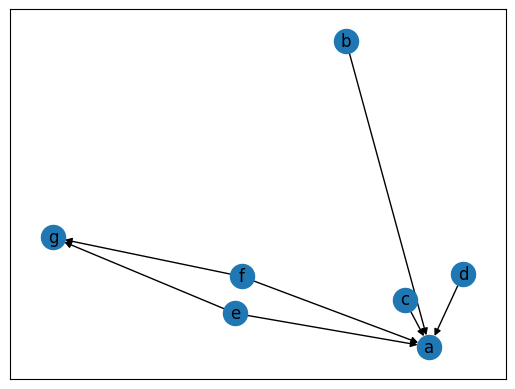

In [12]:
data = {
    'directed': True,
    "nodes": [
        { "id": "a", "country": "East Timor", "code": "tl" },
        { "id": "b", "country": "Canada", "code": "ca" },
        { "id": "c", "country": "Turkmenistan", "code": "tm" },
        { "id": "d", "country": "United States of America", "code": "us" },
        { "id": "e", "country": "Lithuania", "code": "lt" },
        { "id": "f", "country": "Cambodia", "code": "kh" },
        { "id": "g", "country": "Ethiopia", "code": "et" }
    ],
    "links": [
        {"source": 'b', "target": 'a', 'weight': 0.1, 'potato': True},
        {"source": 'c', "target": 'a', 'weight': 2,   'potato': True},
        {"source": 'd', "target": 'a', 'weight': 2,   'potato': True},
        {"source": 'e', "target": 'a', 'weight': 1,   'potato': True},
        {"source": 'f', "target": 'a', 'weight': 1,   'potato': True},
        {"source": 'f', "target": 'g', 'weight': 1,   'potato': False},
        {"source": 'e', "target": 'g', 'weight': 1,   'potato': True},

    ]
}
G = nx.node_link_graph(data)

# print edges with message subject
#for (u, v, d) in H.edges(data=True):
#    print(f"From: {u} To: {v} custom data: {d['potato']}")
    
#H.nodes.get('a')    
    
#nx.draw(H)
options = {
    "font_size": 12,
}

import random
import numpy as np
seed = 123
random.seed(seed)
np.random.seed(seed)

nx.draw_networkx(G,  **options)

{('b', 'a'): Text(-0.2853280271394185, -0.21017481705311458, '0.1'),
 ('c', 'a'): Text(-0.7306323204008491, 0.1670737392476107, '2'),
 ('d', 'a'): Text(-0.34559424857166576, 0.0528165960559529, '2'),
 ('e', 'a'): Text(-0.2889552021129539, 0.16221935626672124, '1'),
 ('e', 'g'): Text(0.5576307181246574, 0.16192189606370666, '1'),
 ('f', 'a'): Text(-0.23581336403579634, -0.3370309600162277, '1'),
 ('f', 'g'): Text(0.610755991983271, -0.33732970625587616, '1')}

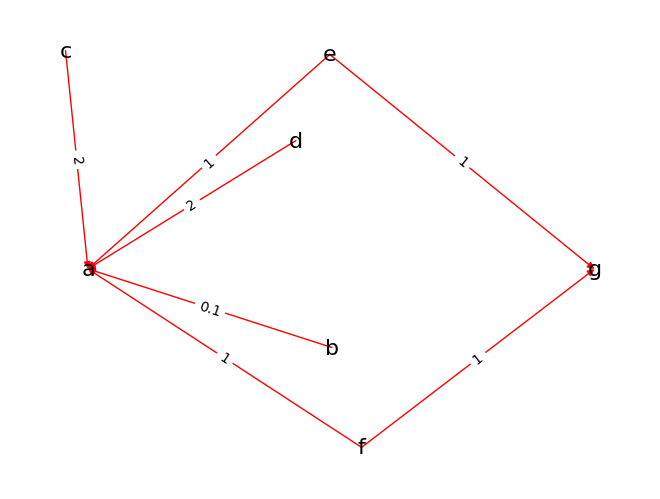

In [13]:
#pos = nx.circular_layout(H)
pos = nx.spring_layout(G, iterations=10, seed=227, weight='weight')
nx.draw(G, pos, node_size=0, alpha=1, edge_color="r", font_size=16, with_labels=True)

labels = nx.get_edge_attributes(G,'weight')
labels = {(k[0], k[1]): v for k,v in labels.items()}
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

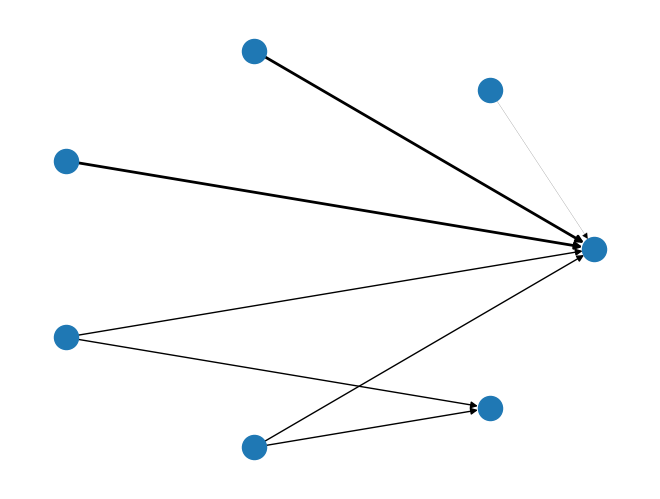

In [14]:
pos = nx.circular_layout(G)
edges = G.edges(data=True)
nx.draw(
    G, 
    pos, 
    #edge_color = [G[u][v]['color'] for u,v in edges], 
    width = [e[2]['weight'] for e in edges]
)


# Upload to blob storage

TODO: I do this manually from the portal. Just upload the index.html to the blob storage that hosts the static webpage